# Machine Configuration

In [35]:
# OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
# SDN4CORE_PATH = "/C/Users/Timo/Workspace/omnet/SDN4CoRE/"
OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
SDN4CORE_PATH = "/C/Users/micro/workspace/omnet/SDN4CoRE/"
SIMULATION_PATH = SDN4CORE_PATH + "examples/papers/vtc2023spring/scaling/"
RESULTFILES_PATTERN = "./results/SDN_Switches_Study-*"

In [36]:
import glob
import pandas as pd
import numpy as np
import ntpath
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

## Helpers:
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Scavetool -- parse filtered result files into csv

In [38]:


MODULE_FILTER = "**.publishers**.middleware.**"
resultfiles = glob.glob(RESULTFILES_PATTERN + ".sca")
for resultfile in resultfiles:
    command = OMNETPP_PATH + "tools\win64\\msys2_shell.cmd -mingw64 -ic \"echo " + resultfile.replace("\\","/").replace(".sca",".*") + "; scavetool x " + SIMULATION_PATH + resultfile.replace("\\","/") + " " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".vec") + " -T v -f \'module(" + MODULE_FILTER + ")\'" + " -o " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".csv") + "; sleep 5\""
    os.environ["HOME"] = OMNETPP_PATH
    os.system(command)
    time.sleep(5)


# Parse Results from csv

In [43]:
csv_files = glob.glob(RESULTFILES_PATTERN + ".csv")
numSwitches = dict()
numNodes = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="vector") & (study.name=="remotes:vector(constant1)")]
    tmp = csv_file.split("-")[1].split(",")
    S = int(tmp[0].split("=")[1])
    N = int(tmp[1].split("=")[1])
    if S not in numSwitches:
        numSwitches[S] = dict()
    if N not in numNodes:
        numNodes[N] = dict()
    numSwitches[S][N] = filtered["vectime"].max()[0]
    numNodes[N][S] = filtered["vectime"].max()[0]
    # lastRemoteMin[S][N] = filtered["vectime"].min()[0]

# Plot results

### Number of nodes for different hop counts

<function matplotlib.pyplot.show(close=None, block=None)>

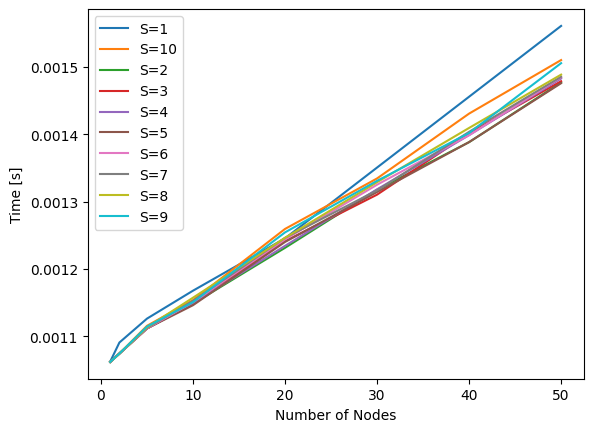

In [44]:
for S in numSwitches.keys():
    # for N in lastRemoteMax[S].keys():
        # print("S=" + str(S) + ", N=" + str(N) + ": " + str(lastRemoteMax[S][N]))
    sortedMax = {key: val for key, val in sorted(numSwitches[S].items(), key = lambda ele: ele[0])}
    plt.plot(sortedMax.keys(), sortedMax.values(), label="S="+str(S))
plt.ylabel("Time [s]")
plt.xlabel("Number of Nodes")
plt.legend()
plt.show

### Number of hops for different node counts

<function matplotlib.pyplot.show(close=None, block=None)>

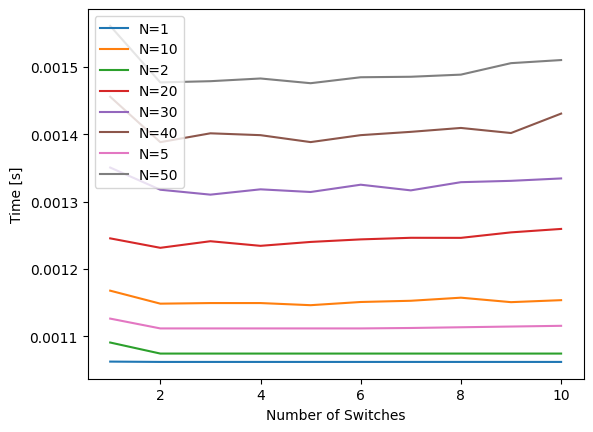

In [45]:
for N in numNodes.keys():
    # for N in lastRemoteMax[S].keys():
        # print("S=" + str(S) + ", N=" + str(N) + ": " + str(lastRemoteMax[S][N]))
    sortedMax = {key: val for key, val in sorted(numNodes[N].items(), key = lambda ele: ele[0])}
    plt.plot(sortedMax.keys(), sortedMax.values(), label="N="+str(N))
plt.ylabel("Time [s]")
plt.xlabel("Number of Switches")
plt.legend()
plt.show